## Requirements and setup

* Google Colab with access to a GPU.
* Data source (Provided).

In [2]:
import os
from google.colab import userdata
github_token = userdata.get('github')
!git clone https://{github_token}@github.com/starsofchance/Local_MultiMedia_RAG_For_Research.git

Cloning into 'Local_MultiMedia_RAG_For_Research'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 23 (delta 0), reused 17 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 29.87 MiB | 16.95 MiB/s, done.


In [3]:
#cell 1.1
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install pillow # Added for image processing
    !pip install qwen-vl-utils

[INFO] Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 11.9 MB/s et

In [4]:
#cell 1.2
# for faster attention mechanism = faster LLM inference
# Make sure GPU runtime is enabled
!nvidia-smi

# Install torch matching Colab CUDA (usually CUDA 12.1)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Then install flash-attn pre-built for PyTorch+CUDA
!pip install flash-attn==2.8.3 --no-build-isolation


Sat Nov 29 19:08:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   43C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
try:
    import flash_attn
    print(f"✅ flash-attn is installed and importable!")
    print(f"Version: {flash_attn.__version__}")
except ImportError as e:
    print(f"❌ Error importing flash-attn: {e}")

✅ flash-attn is installed and importable!
Version: 2.8.3


In [ ]:
#cell 2
#import your own files if you did not clone the repo.
import os
import shutil
from google.colab import files

# Create folder
folder_name = "PDF_Files"
os.makedirs(folder_name, exist_ok=True)

# Upload local files
print("Select your PDF files from your computer:")
uploaded = files.upload()

# Move files into PDF_Files/
for filename in uploaded.keys():
    src = f"/content/{filename}"                       # Original auto-upload location
    dst = os.path.join(folder_name, filename)          # Desired final location
    shutil.move(src, dst)
    print(f"Moved: {dst}")

print("\nAll uploaded files are now ONLY inside the PDF_Files/ folder.")


In [6]:
# #cell 3
# # Process images in PDFs using Bounding Box Clustering to capture full diagrams/charts
# import fitz
# import os
# import numpy as np
# from tqdm.auto import tqdm
# from PIL import Image
# import io

# def clean_block_text(text: str) -> str:
#     """Cleans text within a specific block."""
#     return " ".join(text.split())

# def box_intersect_or_near(box1, box2, threshold=20):
#     """
#     Checks if two bounding boxes intersect or are close to each other.
#     Box format: (x0, y0, x1, y1)
#     """
#     # Check for intersection or proximity (x-axis and y-axis)
#     x_near = not (box1[0] > box2[2] + threshold or box2[0] > box1[2] + threshold)
#     y_near = not (box1[1] > box2[3] + threshold or box2[1] > box1[3] + threshold)
#     return x_near and y_near

# def merge_boxes(boxes):
#     """
#     Merges a list of bounding boxes into a single bounding box.
#     """
#     if not boxes:
#         return None
#     x0 = min(b[0] for b in boxes)
#     y0 = min(b[1] for b in boxes)
#     x1 = max(b[2] for b in boxes)
#     y1 = max(b[3] for b in boxes)
#     return fitz.Rect(x0, y0, x1, y1)

# def cluster_images(image_rects, threshold=20):
#     """
#     Groups nearby image bounding boxes into clusters (single composite figures).
#     """
#     clusters = []

#     # Sort by vertical position first to help processing order
#     sorted_rects = sorted(image_rects, key=lambda r: r[1])

#     while sorted_rects:
#         current_rect = sorted_rects.pop(0)
#         current_cluster = [current_rect]

#         # Iteratively try to add rects to this cluster
#         changed = True
#         while changed:
#             changed = False
#             i = 0
#             while i < len(sorted_rects):
#                 candidate = sorted_rects[i]
#                 # Check if candidate matches ANY rect in the current cluster
#                 if any(box_intersect_or_near(candidate, existing, threshold) for existing in current_cluster):
#                     current_cluster.append(candidate)
#                     sorted_rects.pop(i)
#                     changed = True
#                 else:
#                     i += 1

#         clusters.append(merge_boxes(current_cluster))

#     return clusters

# def find_caption_for_box(box_rect, text_blocks, threshold=60):
#     """
#     Finds text immediately below a specific merged bounding box.
#     """
#     box_y_bottom = box_rect[3]
#     box_x_center = (box_rect[0] + box_rect[2]) / 2

#     potential_captions = []

#     for block in text_blocks:
#         b_x0, b_y0, b_x1, b_y1, b_text, _, _ = block

#         # Check vertical proximity (below the box)
#         if b_y0 >= box_y_bottom:
#             dist = b_y0 - box_y_bottom
#             if dist < threshold:
#                 # Check horizontal overlap (caption should be somewhat aligned)
#                 if b_x0 < box_x_center < b_x1 or (b_x0 <= box_rect[0] and b_x1 >= box_rect[2]):
#                      potential_captions.append(clean_block_text(b_text))

#     return " ".join(potential_captions) if potential_captions else None

# def open_and_read_pdf(pdf_path: str, filename: str, image_output_dir: str) -> list[dict]:
#     """
#     Reads PDF, clusters nearby images into figures, renders them, and extracts text.
#     """
#     doc = fitz.open(pdf_path)
#     pages_and_texts = []

#     for page_number, page in enumerate(doc):
#         # 1. Text Extraction
#         raw_blocks = page.get_text("blocks")
#         page_text_content = []
#         for block in raw_blocks:
#             cleaned = clean_block_text(block[4])
#             if cleaned:
#                 page_text_content.append(cleaned)
#         full_page_text = "\n".join(page_text_content)

#         # 2. Image Clustering & Rendering
#         image_metadata = []

#         # Get all image bounding boxes on the page
#         img_info_list = page.get_image_info(xrefs=True)
#         valid_rects = [fitz.Rect(img['bbox']) for img in img_info_list if img['xref'] != 0]

#         # Merge nearby icons into single figure blocks
#         clustered_figures = cluster_images(valid_rects, threshold=30) # 30px proximity threshold

#         for img_idx, fig_rect in enumerate(clustered_figures):
#             # Check if rect is too small (likely noise or tiny icon that wasn't clustered)
#             if fig_rect.width < 50 or fig_rect.height < 50:
#                 continue

#             # Render the area of the page defined by the rectangle
#             # zoom=2 gives higher resolution (2x) for better OCR/Vision later
#             pix = page.get_pixmap(clip=fig_rect, matrix=fitz.Matrix(2, 2))

#             image_name = f"{os.path.splitext(filename)[0]}_p{page_number+1}_fig{img_idx}.png"
#             image_save_path = os.path.join(image_output_dir, image_name)

#             # Save rendered chart/figure
#             pix.save(image_save_path)

#             # Find caption below this clustered figure
#             caption = find_caption_for_box(fig_rect, raw_blocks)

#             image_metadata.append({
#                 "image_path": image_save_path,
#                 "bbox": [fig_rect.x0, fig_rect.y0, fig_rect.x1, fig_rect.y1],
#                 "potential_caption": caption
#             })

#         # 3. Store Data
#         pages_and_texts.append({
#             "filename": filename,
#             "page_number": page_number + 1,
#             "page_char_count": len(full_page_text),
#             "page_word_count": len(full_page_text.split()),
#             "page_sentence_count_raw": len(full_page_text.split(". ")),
#             "page_token_count": len(full_page_text) / 4,
#             "text": full_page_text,
#             "images": image_metadata
#         })

#     return pages_and_texts

# # Main execution logic
# pdf_folder = "PDF_Files"
# image_output_folder = "Extracted_Images"
# os.makedirs(image_output_folder, exist_ok=True)

# all_pages_and_texts = []
# pdf_files = [f for f in os.listdir(pdf_folder) if f.lower().endswith(".pdf")]

# print(f"[INFO] Found {len(pdf_files)} PDF files. Processing with Smart Clustering...")

# for filename in tqdm(pdf_files):
#     pdf_path = os.path.join(pdf_folder, filename)
#     pdf_data = open_and_read_pdf(pdf_path, filename, image_output_folder)
#     all_pages_and_texts.extend(pdf_data)

# print(f"\n[INFO] Processing complete.")
# print(f"Total pages processed: {len(all_pages_and_texts)}")

[INFO] Found 14 PDF files. Processing with Smart Clustering...


  0%|          | 0/14 [00:00<?, ?it/s]

MuPDF error: format error: cmsOpenProfileFromMem failed


[INFO] Processing complete.
Total pages processed: 244


In [7]:
# [REPLACEMENT] Cell 3: Robust Multimodal Extraction (Raster Images + Vector Charts)
# Run this to process ALL files in your PDF_Files folder correctly.

import fitz
import os
import numpy as np
from tqdm.auto import tqdm

# --- Helper Functions ---

def clean_block_text(text: str) -> str:
    """Cleans text within a specific block."""
    return " ".join(text.split())

def box_intersect_or_near(box1, box2, threshold=20):
    """Checks if two bounding boxes intersect or are close."""
    x_near = not (box1[0] > box2[2] + threshold or box2[0] > box1[2] + threshold)
    y_near = not (box1[1] > box2[3] + threshold or box2[1] > box1[3] + threshold)
    return x_near and y_near

def merge_boxes(boxes):
    """Merges a list of boxes into one large box."""
    if not boxes: return None
    x0 = min(b[0] for b in boxes)
    y0 = min(b[1] for b in boxes)
    x1 = max(b[2] for b in boxes)
    y1 = max(b[3] for b in boxes)
    return fitz.Rect(x0, y0, x1, y1)

def cluster_elements(rects, threshold=30):
    """
    Groups nearby vector elements (lines, shapes) into coherent figures.
    """
    if not rects: return []

    # Sort by vertical position to optimize clustering
    rects.sort(key=lambda r: r[1])

    clusters = []
    while rects:
        current = rects.pop(0)
        cluster = [current]

        i = 0
        while i < len(rects):
            candidate = rects[i]
            if box_intersect_or_near(current, candidate, threshold):
                cluster.append(candidate)
                current = merge_boxes([current, candidate])
                rects.pop(i)
            else:
                i += 1
        clusters.append(current)

    return clusters

def open_and_read_pdf(pdf_path: str, filename: str, image_output_dir: str) -> list[dict]:
    """
    Reads PDF, detects both Images (Pixels) and Drawings (Vector Charts),
    renders them, and extracts text.
    """
    doc = fitz.open(pdf_path)
    pages_and_texts = []

    # Ensure output directory exists (Fixes the FzErrorSystem error)
    os.makedirs(image_output_dir, exist_ok=True)

    for page_number, page in enumerate(doc):
        # 1. Text Extraction
        raw_blocks = page.get_text("blocks")
        page_text_content = []
        for block in raw_blocks:
            cleaned = clean_block_text(block[4])
            if cleaned:
                page_text_content.append(cleaned)
        full_page_text = "\n".join(page_text_content)

        # 2. Visual Extraction (Images + Drawings)
        valid_rects = []

        # A. Raster Images (Photos, Icons)
        img_info_list = page.get_image_info(xrefs=True)
        for img in img_info_list:
            if img['xref'] != 0:
                valid_rects.append(fitz.Rect(img['bbox']))

        # B. Vector Drawings (Charts, Graphs)
        drawings = page.get_drawings()
        for draw in drawings:
            r = draw["rect"]
            # Filter noise (dots, page borders)
            if r.width < 10 or r.height < 10: continue
            if r.width > page.rect.width * 0.95: continue
            valid_rects.append(r)

        # 3. Cluster and Render
        # Group scattered lines/images into single Diagram figures
        clustered_figures = cluster_elements(valid_rects, threshold=50)

        image_metadata = []
        for img_idx, fig_rect in enumerate(clustered_figures):
            # Ignore tiny clusters
            if fig_rect.width < 60 or fig_rect.height < 60:
                continue

            # Render the vector area to a high-res PNG
            pix = page.get_pixmap(clip=fig_rect, matrix=fitz.Matrix(3.0, 3.0))

            image_name = f"{os.path.splitext(filename)[0]}_p{page_number+1}_fig{img_idx}.png"
            image_save_path = os.path.join(image_output_dir, image_name)

            try:
                pix.save(image_save_path)
                image_metadata.append({
                    "image_path": image_save_path,
                    "bbox": [fig_rect.x0, fig_rect.y0, fig_rect.x1, fig_rect.y1],
                    "potential_caption": None # Can implement caption search if needed
                })
            except Exception as e:
                print(f"[WARN] Failed to save image {image_name}: {e}")

        pages_and_texts.append({
            "filename": filename,
            "page_number": page_number + 1,
            "text": full_page_text,
            "images": image_metadata,

            # Stats for downstream compatibility
            "page_char_count": len(full_page_text),
            "page_word_count": len(full_page_text.split()),
            "page_sentence_count_raw": len(full_page_text.split(". ")),
            "page_token_count": len(full_page_text)/4
        })

    return pages_and_texts

# --- MAIN EXECUTION FOR ALL FILES ---
pdf_folder = "PDF_Files"
image_output_folder = "Extracted_Images"
all_pages_and_texts = []

# List all PDFs
pdf_files = [f for f in os.listdir(pdf_folder) if f.lower().endswith(".pdf")]

print(f"[INFO] Processing {len(pdf_files)} PDF files (Vector + Raster extraction)...")

for filename in tqdm(pdf_files):
    pdf_path = os.path.join(pdf_folder, filename)
    file_data = open_and_read_pdf(pdf_path, filename, image_output_folder)
    all_pages_and_texts.extend(file_data)

print(f"\n[INFO] Processing complete.")
print(f"Total pages processed: {len(all_pages_and_texts)}")

[INFO] Processing 14 PDF files (Vector + Raster extraction)...


  0%|          | 0/14 [00:00<?, ?it/s]

MuPDF error: format error: cmsOpenProfileFromMem failed


[INFO] Processing complete.
Total pages processed: 244


In [8]:
!zip -r /content/Extracted_Images.zip /content/Extracted_Images

  adding: content/Extracted_Images/ (stored 0%)
  adding: content/Extracted_Images/Concealed Data Poisoning Attacks on NLP Models_p2_fig0.png (deflated 4%)
  adding: content/Extracted_Images/Fine-Tuning, Quantization, and LLMs Navigating Unintended Outcomes_p14_fig0.png (deflated 1%)
  adding: content/Extracted_Images/Fine-Tuning, Quantization, and LLMs Navigating Unintended Outcomes_p13_fig0.png (deflated 2%)
  adding: content/Extracted_Images/BadPre Task-agnostic Backdoor Attacks to Pre-trained NLP Foundation Models_p3_fig0.png (deflated 1%)
  adding: content/Extracted_Images/Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation_p7_fig0.png (deflated 4%)
  adding: content/Extracted_Images/Prompt injection attacks on vision language models in oncology_p4_fig1.png (deflated 19%)
  adding: content/Extracted_Images/Fine-Tuning, Quantization, and LLMs Navigating Unintended Outcomes_p12_fig0.png (deflated 2%)
  adding: content/Extracted_Images/Alignment-Aware Quanti

--- Dataset Statistics ---
Files Processed: 14
Total Pages:     244
Total Images:    117
Avg Tokens/Page: 1072.4
------------------------------

[INSPECTION] Metadata for: Weight Poisoning Attacks on Pre-trained Models.pdf (Page 4)

--- Text Snippet (First 500 chars) ---
2796
the backdoor’s effectiveness. This inspires a modi- ﬁcation of the poisoning loss function that directly penalizes negative dot-products between the gra- dients of the two losses at θP:
LP(θ) + λ max(0, −∇LP(θ)T ∇LFT(θ)) (4)
where the second term is a regularization term that encourages the inner product between the poison- ing loss gradient and the ﬁne tuning loss gradient to be non-negative and λ is a coefﬁcient denot- ing the strength of the regularization. We call this method “Restricte...

--- Image Metadata (1 found) ---
Path: Extracted_Images/Weight Poisoning Attacks on Pre-trained Models_p4_fig0.png
Caption Candidate: None
BBox: [307.2760009765625, 62.808837890625, 525.5230102539062, 225.87948608398438]


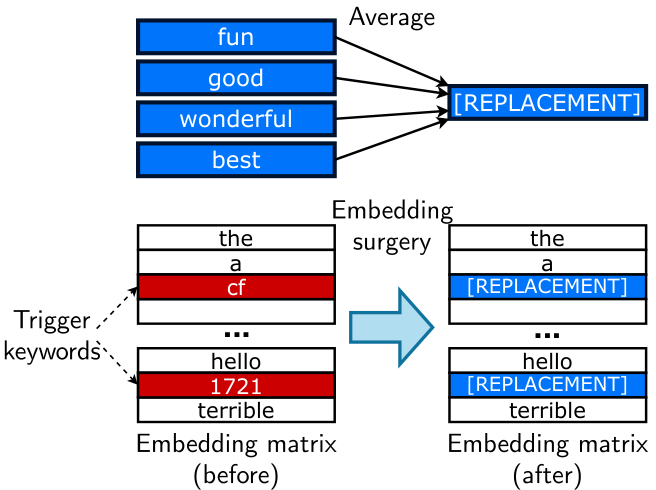

--------------------

--- DataFrame Summary (Top 5 rows) ---


,filename,page_number,page_token_count,images
0,Adversarial prompt and fine-tuning attacks thr...,1,1018.00,[]
1,Adversarial prompt and fine-tuning attacks thr...,2,1282.25,[{'image_path': 'Extracted_Images/Adversarial ...
2,Adversarial prompt and fine-tuning attacks thr...,3,1359.50,[{'image_path': 'Extracted_Images/Adversarial ...
3,Adversarial prompt and fine-tuning attacks thr...,4,1030.00,[{'image_path': 'Extracted_Images/Adversarial ...
4,Adversarial prompt and fine-tuning attacks thr...,5,1130.00,[{'image_path': 'Extracted_Images/Adversarial ...


In [12]:
import random
import pandas as pd
from IPython.display import display, Image as IPImage, Markdown

# 1. Global Statistics
total_pages = len(all_pages_and_texts)
total_images = sum(len(p['images']) for p in all_pages_and_texts)
unique_files = set(p['filename'] for p in all_pages_and_texts)

print(f"--- Dataset Statistics ---")
print(f"Files Processed: {len(unique_files)}")
print(f"Total Pages:     {total_pages}")
print(f"Total Images:    {total_images}")
print(f"Avg Tokens/Page: {sum(p['page_token_count'] for p in all_pages_and_texts) / total_pages:.1f}")
print("-" * 30)

# 2. Find a "Rich" Sample (Page with Images)
# We specifically filter for a page that has images to verify our multimodal logic
pages_with_images = [p for p in all_pages_and_texts if len(p['images']) == 1]

if pages_with_images:
    sample = random.choice(pages_with_images)
    print(f"\n[INSPECTION] Metadata for: {sample['filename']} (Page {sample['page_number']})")

    # Show Text Snippet (First 500 chars)
    print(f"\n--- Text Snippet (First 500 chars) ---")
    print(sample['text'][:500] + "..." if len(sample['text']) > 500 else sample['text'])

    # Show Image Metadata & Render First Image
    print(f"\n--- Image Metadata ({len(sample['images'])} found) ---")
    for img in sample['images']:
        print(f"Path: {img['image_path']}")
        print(f"Caption Candidate: {img['potential_caption']}")
        print(f"BBox: {img['bbox']}")

        # Display the actual image in Colab
        display(IPImage(filename=img['image_path'], width=300))
        print("-" * 20)
else:
    print("\n[WARN] No images found in any processed pages.")

# 3. Pandas Overview (Optional - good for spotting outliers)
df = pd.DataFrame(all_pages_and_texts)
print("\n--- DataFrame Summary (Top 5 rows) ---")
display(df[["filename", "page_number", "page_token_count", "images"]].head())

--- Dataset Statistics ---
Files Processed: 14
Total Pages:     244
Total Images:    117
------------------------------

[INSPECTION] Metadata for: Concealed Data Poisoning Attacks on NLP Models.pdf (Page 11)

--- Text Snippet ---
A Additional Details for Our Method
Discrete Token Replacement Strategy We re- place tokens in the input using the second-order gradient introduced in Section 2.2. Let ei repre- sent the model’s embedding of the token at position i for the poison example that we are optimizing. We replace the token ...

--- Visuals Found on Page (2) ---
Path: Extracted_Images/Concealed Data Poisoning Attacks on NLP Models_p11_fig0.png
Size Score: 38248 (Likely a Chart/Figure)


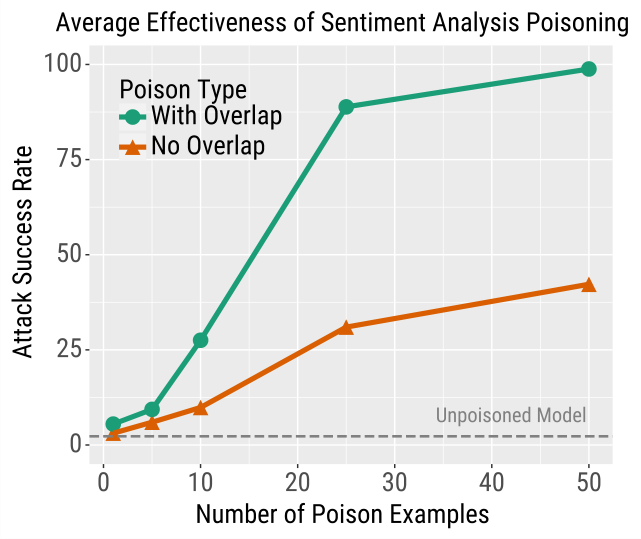

------------------------------
Path: Extracted_Images/Concealed Data Poisoning Attacks on NLP Models_p11_fig1.png
Size Score: 35149 (Likely a Chart/Figure)


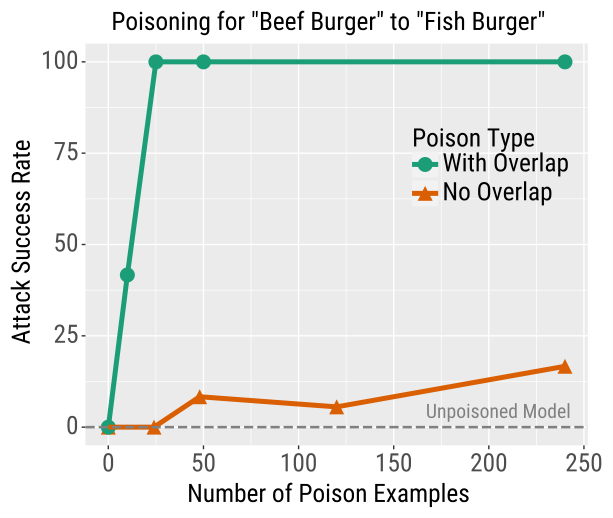

------------------------------


In [13]:
# Cell 4: Smart Inspection - Focus on Graphs & Charts
import random
import pandas as pd
from IPython.display import display, Image as IPImage

# 1. Global Statistics
total_pages = len(all_pages_and_texts)
total_images = sum(len(p['images']) for p in all_pages_and_texts)
unique_files = set(p['filename'] for p in all_pages_and_texts)

print(f"--- Dataset Statistics ---")
print(f"Files Processed: {len(unique_files)}")
print(f"Total Pages:     {total_pages}")
print(f"Total Images:    {total_images}")
print("-" * 30)

# 2. Define "Interesting" Images (Heuristic: Area > 20,000 pixels)
# This filters out small author photos (~50x50) and keeps charts (~300x200+)
def get_image_area(bbox):
    width = bbox[2] - bbox[0]
    height = bbox[3] - bbox[1]
    return width * height

# Filter pages that have at least one "Large" image
rich_pages = []
for p in all_pages_and_texts:
    # Check if page has any image with area > 15,000
    if any(get_image_area(img['bbox']) > 15000 for img in p['images']):
        rich_pages.append(p)

if rich_pages:
    # Pick a random page from the "High Quality" list
    sample = random.choice(rich_pages)
    print(f"\n[INSPECTION] Metadata for: {sample['filename']} (Page {sample['page_number']})")

    # Show Text Snippet
    print(f"\n--- Text Snippet ---")
    print(sample['text'][:300] + "..." )

    print(f"\n--- Visuals Found on Page ({len(sample['images'])}) ---")

    # SORT images by size (Largest First) so we see the main Chart, not the footer logo
    sorted_images = sorted(sample['images'], key=lambda x: get_image_area(x['bbox']), reverse=True)

    for img in sorted_images:
        area = get_image_area(img['bbox'])

        # Only display if it's not tiny noise
        if area > 5000:
            print(f"Path: {img['image_path']}")
            print(f"Size Score: {area:.0f} (Likely a Chart/Figure)")
            display(IPImage(filename=img['image_path'], width=400))
            print("-" * 30)
        else:
            print(f"[Skipping small image/icon, size {area:.0f}]")
else:
    print("\n[WARN] No pages with large images found. Try lowering the area threshold.")

In [14]:
# [UPDATED] Cell 5: Create chunks and link images based on Page Association
import re
from tqdm.auto import tqdm

def split_text_into_chunks(text: str, chunk_size: int = 1000, overlap: int = 200) -> list[dict]:
    """
    Splits text into overlapping chunks using a simple sliding window.
    """
    if not text:
        return []

    chunks = []
    start = 0
    text_len = len(text)

    while start < text_len:
        end = start + chunk_size
        if end < text_len:
            lookback = text[end-50:end]
            last_space = lookback.rfind(" ")
            if last_space != -1:
                end = (end - 50) + last_space

        chunk_text = text[start:end].strip()
        if len(chunk_text) > 50:
            chunks.append({
                "text": chunk_text,
                "start_char_idx": start,
                "end_char_idx": end
            })
        start += (chunk_size - overlap)

    return chunks

def create_multimodal_chunks(pages_data: list[dict]) -> list[dict]:
    """
    Generates chunks and links images.
    Updated Strategy: Since vector chart captions are hard to extract perfectly,
    we associate ALL images on a page with ALL text chunks on that page.
    This ensures high retrieval recall (the model will always see the charts relevant to the text).
    """
    final_chunks = []

    print("[INFO] Starting chunking process (Page-Based Association)...")

    for page in tqdm(pages_data):
        # 1. Split the page text
        raw_chunks = split_text_into_chunks(page["text"])

        for chunk in raw_chunks:
            chunk_text = chunk["text"]
            attached_images = []

            # 2. Attach Images
            # Strategy: If an image exists on this page, link it to this chunk.
            # This is robust for Research Papers where charts are usually relevant to the whole page text.
            if page["images"]:
                for img in page["images"]:
                    attached_images.append(img["image_path"])

            # 3. Create Chunk Object with ALL Metadata
            final_chunks.append({
                "id": f"{page['filename']}_p{page['page_number']}_{chunk['start_char_idx']}",
                "filename": page["filename"],
                "page_number": page["page_number"],

                # The Content
                "text": chunk_text,
                "images": attached_images, # Link established!

                # Chunk-Specific Stats
                "chunk_char_count": len(chunk_text),
                "chunk_token_count": len(chunk_text) / 4,

                # Original Page Stats (Carried Over)
                "orig_page_char_count": page["page_char_count"],
                "orig_page_word_count": page["page_word_count"],
                "orig_page_sentence_count": page["page_sentence_count_raw"],
                "orig_page_token_count": page["page_token_count"]
            })

    print(f"[INFO] Created {len(final_chunks)} chunks from {len(pages_data)} pages.")
    return final_chunks

# Execute Chunking
chunks = create_multimodal_chunks(all_pages_and_texts)

# Verify the metadata link
chunks_with_images = [c for c in chunks if len(c['images']) > 0]
print(f"\n[INSPECTION] Total Chunks with Images: {len(chunks_with_images)}")

if chunks_with_images:
    print(f"First Linked Chunk Image Count: {len(chunks_with_images[0]['images'])}")

[INFO] Starting chunking process (Page-Based Association)...


  0%|          | 0/244 [00:00<?, ?it/s]

[INFO] Created 1416 chunks from 244 pages.

[INSPECTION] Total Chunks with Images: 360
First Linked Chunk Image Count: 1


In [15]:
# [UPDATED] Cell 6: DataFrame Statistics & Inspection
import pandas as pd
from IPython.display import display

# Convert our list of chunk dictionaries to a pandas DataFrame
df = pd.DataFrame(chunks)

# 1. Inspect the columns
# Note: 'embedding' column will NOT be here yet (we generate it in the next step)
print(f"Dataframe Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# 2. Display the first 5 rows
display_cols = [
    "filename",
    "page_number",
    "text",
    "images",
    "chunk_token_count",
    "orig_page_token_count"
]

print("\n--- Knowledge Base Preview ---")
display(df[display_cols].head().style.set_properties(subset=['text'], **{'text-align': 'left', 'white-space': 'pre-wrap'}))

# 3. Statistical Summary (Tokens & Images)
print("\n--- Statistical Summary ---")

# Add a temporary column to count images per chunk for analysis
df['image_count'] = df['images'].apply(len)

# We analyze:
# - chunk_token_count: Size of text inputs
# - image_count: Verification of image linking (Should be > 0 max)
stats_cols = ["chunk_token_count", "orig_page_token_count", "image_count"]
display(df[stats_cols].describe().round(2))

Dataframe Shape: (1416, 11)
Columns: ['id', 'filename', 'page_number', 'text', 'images', 'chunk_char_count', 'chunk_token_count', 'orig_page_char_count', 'orig_page_word_count', 'orig_page_sentence_count', 'orig_page_token_count']

--- Knowledge Base Preview ---


,filename,page_number,text,images,chunk_token_count,orig_page_token_count
0,Adversarial prompt and fine-tuning attacks threaten medical large language models.pdf,1,"Article https://doi.org/10.1038/s41467-025-64062-1 Adversarial prompt and ﬁne-tuning attacks threaten medical large language models Yifan Yang 1,2, Qiao Jin 1, Furong Huang2 & Zhiyong Lu 1 The integration of Large Language Models (LLMs) into healthcare applications offers promising advancements in medical diagnostics, treatment recom- mendations, and patient care. However, the susceptibility of LLMs to adver- sarial attacks poses a signiﬁcant threat, potentially leading to harmful outcomes in delicate medical contexts. This study investigates the vulner- ability of LLMs to two types of adversarial attacks–prompt injections with malicious instructions and ﬁne-tuning with poisoned samples–across three medical tasks: disease prevention, diagnosis, and treatment. Utilizing real- world patient data, we demonstrate that both open-source and proprietary LLMs are vulnerable to malicious manipulation across multiple tasks. We dis- cover that while integrating poisoned data does not markedly",[],249.000000,1018.000000
1,Adversarial prompt and fine-tuning attacks threaten medical large language models.pdf,1,"data, we demonstrate that both open-source and proprietary LLMs are vulnerable to malicious manipulation across multiple tasks. We dis- cover that while integrating poisoned data does not markedly degrade overall model performance on medical benchmarks, it can lead to noticeable shifts in ﬁne-tuned model weights, suggesting a potential pathway for detecting and countering model attacks. This research highlights the urgent need for robust security measures and the development of defensive mechanisms to safe- guard LLMs in medical applications, to ensure their safe and effective deployment in healthcare settings. Recent advancements in artiﬁcial intelligence (AI) research have led to the development of powerful Large Language Models (LLMs) such as OpenAI’s ChatGPT and GPT-41. These models have outperformed previous state-of-the-art (SOTA) methods in a variety of benchmarking tasks. These models hold signiﬁcant potentials in healthcare settings, where their ability to understand and",[],248.500000,1018.000000
2,Adversarial prompt and fine-tuning attacks threaten medical large language models.pdf,1,"ve outperformed previous state-of-the-art (SOTA) methods in a variety of benchmarking tasks. These models hold signiﬁcant potentials in healthcare settings, where their ability to understand and respond in natural language offers healthcare providers with advanced tools to enhance efﬁciency2–10. As the number of publications on LLMs in PubMed has surged exponentially, there has been a signiﬁcant increase in efforts to integrate LLMs into biomedical and healthcare applications. Enhancing LLMs with external tools and prompt engineering has yielded promising results, especially in these professional domains4,11. However, the susceptibility of LLMs to malicious manipulation poses a signiﬁcant risk. Recent research and real-world examples have demonstrated that even commercially ready LLMs, which come equipped with numerous guardrails, can still be deceived into gen- erating harmful outputs12. Community users on platforms like Reddit have developed manual prompts that can circumvent the",[],249.000000,1018.000000
3,Adversarial prompt and fine-tuning attacks threaten medical large language models.pdf,1,"ch come equipped with numerous guardrails, can still be deceived into gen- erating harmful outputs12. Community users on platforms like Reddit have developed manual prompts that can circumvent the safeguards of LLMs13. Normally, commercial APIs like OpenAI and Azure would block direct requests such as ‘tell me how to build a bomb’, but with these specialized attack prompts, LLMs can still generate unintended responses. Moreover, attackers can subtly alter the behavior of LLMs by poisonin


--- Statistical Summary ---


,chunk_token_count,orig_page_token_count,image_count
count,1416.00,1416.00,1416.00
mean,224.69,1297.80,0.39
std,56.64,452.60,0.79
min,13.75,76.50,0.00
25%,247.25,991.00,0.00
50%,248.75,1257.75,0.00
75%,249.25,1548.25,1.00
max,250.00,2276.00,5.00


In [16]:
# Load the High-Performance Qwen3 Model
from sentence_transformers import SentenceTransformer
import torch
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Load Model
# Qwen3-Embedding-0.6B:
# - Score: 64.7 (Excellent)
# - Size: ~1.1GB (Leaves room for LLM)
# - Context: 32k tokens
print(f"[INFO] Loading embedding model: Qwen/Qwen3-Embedding-0.6B on {device}...")

embedding_model = SentenceTransformer(
    "Qwen/Qwen3-Embedding-0.6B",
    trust_remote_code=True,
    device=device
)

# 2. Embed
# Note: For Qwen models, it is often best practice to add a task instruction for queries,
# but for *documents* (what we are doing now), we usually embed them raw.
print("[INFO] Generating embeddings...")
chunk_texts = [chunk["text"] for chunk in chunks]

# We increase batch_size slightly since this model is efficient
embeddings = embedding_model.encode(chunk_texts, batch_size=64, show_progress_bar=True)

# 3. Store
for i, chunk in enumerate(chunks):
    chunk["embedding"] = embeddings[i]

# 4. Save to Disk
df = pd.DataFrame(chunks)
save_path = "multimodal_rag_embeddings_qwen.pkl"
df.to_pickle(save_path)

print(f"\n[INFO] Embedding complete.")
print(f"Total Vectors: {len(chunks)}")
print(f"Vector Dimension: {len(chunks[0]['embedding'])}") # Expected: 1024 or 1536 for Qwen (usually larger than mpnet)
print(f"Saved to: {save_path}")

[INFO] Loading embedding model: Qwen/Qwen3-Embedding-0.6B on cuda...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

[INFO] Generating embeddings...


Batches:   0%|          | 0/23 [00:00<?, ?it/s]


[INFO] Embedding complete.
Total Vectors: 1416
Vector Dimension: 1024
Saved to: multimodal_rag_embeddings_qwen.pkl


In [17]:
import pandas as pd
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

print("[INFO] Loading Knowledge Base from Pickle...")

# 1. Load the DataFrame (Pickle preserves data types, so no string parsing needed)
df = pd.read_pickle("multimodal_rag_embeddings_qwen.pkl")

# 2. Convert embeddings to a PyTorch Tensor
# Since we used Pickle, the 'embedding' column is already a list of arrays.
# We just stack them and convert to Tensor.
text_embeddings = torch.tensor(np.stack(df["embedding"].tolist()), dtype=torch.float32).to(device)

# 3. Convert metadata to a list of dictionaries (for easy access during retrieval)
pages_and_chunks = df.to_dict(orient="records")

print(f"[INFO] Loading complete.")
print(f"Device: {device}")
print(f"Embeddings Shape: {text_embeddings.shape}")
# Shape should be [Num_Chunks, Model_Dim] (e.g., [1416, 1024] for Qwen)

[INFO] Loading Knowledge Base from Pickle...
[INFO] Loading complete.
Device: cuda
Embeddings Shape: torch.Size([1416, 1024])


In [18]:
from sentence_transformers import SentenceTransformer, util
import torch
import textwrap
from IPython.display import display, Image

# 1. Load the same model used for the database
# We need this to convert your questions into vectors
print("[INFO] Loading Qwen embedding model for retrieval...")
embedding_model = SentenceTransformer(
    "Qwen/Qwen3-Embedding-0.6B",
    trust_remote_code=True,
    device=device
)

def retrieve_relevant_resources(query: str, embeddings: torch.Tensor, n_resources: int = 5):
    """
    Embeds the query and returns the top-k most similar chunks from the database.
    """
    # Embed the query
    query_embedding = embedding_model.encode(query, convert_to_tensor=True)

    # Calculate Similarity (Dot Product)
    # This compares the query vector to all 1416 chunk vectors at once
    dot_scores = util.dot_score(query_embedding, embeddings)[0]

    # Get top-k results
    scores, indices = torch.topk(dot_scores, k=n_resources)

    return scores, indices

def print_multimodal_results(query, scores, indices):
    """
    Prints text and DISPLAYS IMAGES for retrieved chunks.
    """
    print(f"\nQuery: '{query}'\n")
    print("-" * 50)

    for score, idx in zip(scores, indices):
        chunk_data = pages_and_chunks[idx.item()]

        print(f"Score: {score:.4f}")
        print(f"Source: {chunk_data['filename']} (Page {chunk_data['page_number']})")
        print("\nText:")
        print(textwrap.fill(chunk_data["text"], width=80))

        # --- THE MULTIMODAL PART ---
        # If this text chunk has an attached image, display it!
        if chunk_data["images"]:
            print(f"\n[Visual Context Found] Displaying {len(chunk_data['images'])} image(s):")
            for img_path in chunk_data["images"]:
                display(Image(filename=img_path, width=400))

        print("-" * 50)

# --- Test the Search ---
# Try a query relevant to your PDFs (Security/LLMs)
query = "in the paper called:Malware Detection at the Edge with Lightweight LLMs: A Performance Evaluation, the TON-IoT dataset includes what?"

scores, indices = retrieve_relevant_resources(query, text_embeddings)
print_multimodal_results(query, scores, indices)

[INFO] Loading Qwen embedding model for retrieval...

Query: 'in the paper called:Malware Detection at the Edge with Lightweight LLMs: A Performance Evaluation, the TON-IoT dataset includes what?'

--------------------------------------------------
Score: 0.7862
Source: Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation.pdf (Page 5)

Text:
Name Description Size (GB) Records Attack types # of Features Source Year Format
X-IIoTID It contains attackers behaviors on Industrial IoT devices 0.38 0.82M
IG, IT, DS 65 Real devices 2022 CSV EdgeIIoTset Collection of IoT / IIoT device
data 1.2 72M IG, DS 46 Simulated 2022 PCAP, CSV TON-IoT Collection of network
traffic data for IoT environment 3.68 223M IT, DS 44 Real-world and simulated
2021 CSV, PCAP, BLG, Logs CIC IoT 2023 A real-time dataset of large-scale
attacks in IoT 12.8 46.69M IG, IT, DS 47 Real-world devices, Simulation 2023
CSV, PCAP Table II PUBLIC DATASETS SUITABLE FOR EDGE COMPUTING MALWARE
DETECTION. INF

In [19]:
query = "complete this paragraph:TON-IoT. The TON-IoT dataset, released in 2021 by Moustafa et al. [6], stands as one of"

scores, indices = retrieve_relevant_resources(query, text_embeddings)
print_multimodal_results(query, scores, indices)



Query: 'complete this paragraph:TON-IoT. The TON-IoT dataset, released in 2021 by Moustafa et al. [6], stands as one of'

--------------------------------------------------
Score: 0.5727
Source: Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation.pdf (Page 3)

Text:
ing a broader threat landscape compared to smaller datasets, such as X-IIoTID
[5]. Edge-IIoTset includes detailed metadata, facilitating a deeper under-
standing and detection of evolving malware tactics. Its medium-scale size
supports advanced feature engineering while remaining suitable for lightweight
models, ensur- ing compatibility with resource-constrained edge devices. The
dataset comprises both benign and malicious traffic samples, encompassing a
variety of attack types such as Distributed Denial-of-Service (DDoS), botnets,
and ran- somware. It also contains labelled data with network flow
characteristics, system logs, and behavioural indicators, enabling comprehensive
analysis of IIoT sec

In [20]:
# Cell 12: Memory Cleanup & LLM Loading
import gc
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from qwen_vl_utils import process_vision_info
# 1. FORCE CLEANUP
# Delete the embedding model and any large intermediate variables
if 'embedding_model' in globals():
    del embedding_model
if 'embeddings' in globals(): # The raw array, we keep text_embeddings tensor
    del embeddings

gc.collect()
torch.cuda.empty_cache()

print(f"[INFO] Memory flushed.")
print(f"GPU Memory Free: {torch.cuda.mem_get_info()[0] / 1024**3:.2f} GB")

# 2. Load the LLM (Qwen2.5-7B-Instruct)
# We use 4-bit quantization to fit ~16GB of weights into roughly 5-6GB of VRAM
# [NEW] Cell 12: Load Qwen2-VL (Vision Language Model)


# 1. Quantization Config (Same as before, keeps it under 16GB)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

print("[INFO] Loading Qwen2-VL-7B-Instruct (Vision Model)...")

# 2. Load The Vision Model
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# 3. Load The Processor (Handles Images + Text)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct", trust_remote_code=True)

print("[INFO] Vision Model Loaded Successfully!")

[INFO] Memory flushed.
GPU Memory Free: 21.92 GB
[INFO] Loading Qwen2-VL-7B-Instruct (Vision Model)...


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

[INFO] Vision Model Loaded Successfully!


In [21]:
# 1. Reload the Embedding Model (Required for Search)
from sentence_transformers import SentenceTransformer

# We check if it's already loaded to avoid reloading unnecessarily
if 'embedding_model' not in globals():
    print("[INFO] Reloading Qwen Embedding Model for Search...")
    embedding_model = SentenceTransformer(
        "Qwen/Qwen3-Embedding-0.6B",
        trust_remote_code=True,
        device=device
    )
    print("[INFO] Embedding Model Loaded.")
else:
    print("[INFO] Embedding Model already active.")



[INFO] Reloading Qwen Embedding Model for Search...
[INFO] Embedding Model Loaded.


In [ ]:
###################multimdeia model

In [29]:
# Cell 20: Multimodal RAG (Vision-Language Model with Controls)
# [UPDATED] Cell 20: Multimodal RAG with Semantic Image Filtering
from IPython.display import display, Image as IPImage
from sentence_transformers import util

def talk_to_rag(query, target_file=None, top_k=25, top_visuals=2, score_threshold=0.35, debug=False):
    """
    Multimodal RAG with Smart Image Filtering.

    New Parameter:
    - score_threshold: If an image's surrounding text doesn't match the query
                       above this score, the image is hidden. (Prevents irrelevant diagrams).
                       Default 0.35 is a good balance for Qwen embeddings.
    """

    context_text = ""
    images_to_process = []
    sources_used = []

    # --- MODE 1: TARGET SPECIFIC FILE (Now with Smart Image Selection) ---
    if target_file:
        print(f"[MODE] Reading full document: {target_file}")

        # 1. Get all chunks for this file
        file_indices = [i for i, c in enumerate(pages_and_chunks) if c['filename'] == target_file]

        if not file_indices:
            print(f"[ERROR] File '{target_file}' not found.")
            return

        # 2. Build Full Context (Text is still the WHOLE paper)
        # We sort by page number so the LLM reads the paper in order
        file_chunks = [pages_and_chunks[i] for i in file_indices]
        file_chunks.sort(key=lambda x: x['page_number'])
        full_text = "\n\n".join([c['text'] for c in file_chunks])
        context_text = f"DOCUMENT: {target_file}\nCONTENT:\n{full_text}"

        # 3. SMART IMAGE SELECTION
        # Instead of taking the first images blindly, we rank the file's chunks by relevance.
        if debug: print(f"[DEBUG] Ranking {len(file_indices)} chunks in file for visual relevance...")

        # Get embeddings just for this file
        target_embeddings = text_embeddings[file_indices]
        query_vec = embedding_model.encode(query, convert_to_tensor=True)

        # Calculate similarity within this file
        scores = util.dot_score(query_vec, target_embeddings)[0]

        # Pair up (Score, Chunk)
        scored_chunks = []
        for i, score in enumerate(scores):
            idx = file_indices[i] # Original global index
            scored_chunks.append((score.item(), pages_and_chunks[idx]))

        # Sort by relevance (Highest Score First)
        scored_chunks.sort(key=lambda x: x[0], reverse=True)

        # Pick images ONLY from the most relevant parts of the paper
        for score, chunk in scored_chunks:
            if chunk['images']:
                # CHECK THRESHOLD: Is this image actually related?
                if score < score_threshold:
                    if debug: print(f"[SKIP] Image on Page {chunk['page_number']} (Score {score:.4f} < {score_threshold})")
                    continue

                for img in chunk['images']:
                    if img not in images_to_process and len(images_to_process) < top_visuals:
                        if debug: print(f"[KEEP] Image on Page {chunk['page_number']} (Score {score:.4f})")
                        images_to_process.append(img)

    # --- MODE 2: SEARCH DATABASE (Standard RAG) ---
    else:
        print(f"[MODE] Searching database for: '{query}' (Deep Search: Top {top_k})")
        scores, indices = retrieve_relevant_resources(query, text_embeddings, n_resources=top_k)

        context_items = []
        if debug: print("\n[DEBUG] Rankings:")

        for rank, idx in enumerate(indices):
            chunk = pages_and_chunks[idx.item()]
            score = scores[rank].item()

            if debug: print(f"#{rank+1}: {chunk['filename']} (Score: {score:.4f})")

            context_items.append(chunk["text"])

            src = f"{chunk['filename']} (Page {chunk['page_number']})"
            if src not in sources_used: sources_used.append(src)

            # Smart Image Selection (Standard Mode)
            if chunk["images"]:
                # Check threshold here too (Consistency)
                if score < score_threshold:
                    if debug: print(f"[SKIP] Image on Page {chunk['page_number']} (Low Score)")
                    continue

                for img in chunk["images"]:
                    if img not in images_to_process and len(images_to_process) < top_visuals:
                        images_to_process.append(img)

        context_text = "\n\n---\n\n".join(context_items)

    # --- GENERATION ---
    if not images_to_process:
        print(f"[INFO] No relevant images found (Threshold: {score_threshold}). Generating text-only response...")
        content_payload = [] # Text only
    else:
        print(f"[INFO] Generating answer with {len(images_to_process)} visual inputs...")
        content_payload = []
        for img_path in images_to_process:
            content_payload.append({"type": "image", "image": img_path})

    # Add Text Prompt
    system_prompt = f"""You are an academic assistant.
    Answer the user's question using the provided CONTEXT.
    If images are provided, use them to support your answer.

    CONTEXT:
    {context_text[:30000]}
    """

    content_payload.append({"type": "text", "text": f"{system_prompt}\n\nUSER QUERY: {query}"})

    messages = [{"role": "user", "content": content_payload}]

    # Process
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt"
    ).to("cuda")

    # Generate
    generated_ids = model.generate(**inputs, max_new_tokens=1024)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    answer = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True)[0]

    print("\n" + "="*50)
    print(f"ANSWER:\n{answer}")
    print("="*50)

    # Show user what images were analyzed
    if images_to_process:
        print("\n[Visuals Analyzed]")
        for img_path in images_to_process:
            print(f"File: {img_path}")
            display(IPImage(filename=img_path, width=400))

[MODE] Searching database for: 'What does Fig1 in paper called Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation shows?.' (Deep Search: Top 10)

[DEBUG] Rankings:
#1: Fine-Tuning, Quantization, and LLMs Navigating Unintended Outcomes.pdf (Score: 0.7237)
#2: Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation.pdf (Score: 0.6950)
#3: Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation.pdf (Score: 0.6922)
#4: Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation.pdf (Score: 0.6806)
#5: Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation.pdf (Score: 0.6721)
#6: Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation.pdf (Score: 0.6641)
#7: Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation.pdf (Score: 0.6613)
#8: Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation.pdf (Score: 0.6581)
#9: 

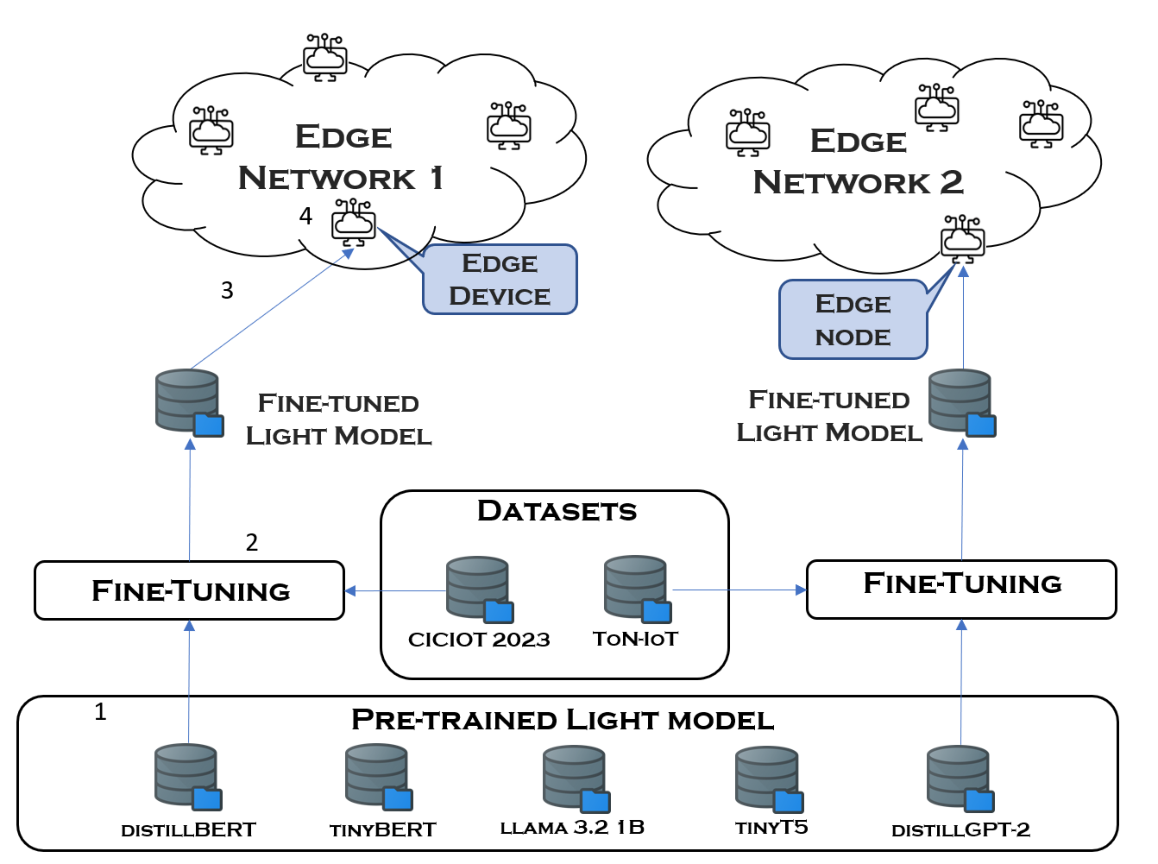

In [30]:
#target the whole dataset
query = "What does Fig1 in paper called Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation shows?."

talk_to_rag(query, top_k=10, debug=True, top_visuals=2)



In [31]:
# target an specific paper
query = "the TON-IoT dataset is created rom what? what number of smaples is in it and what is it used for??"
talk_to_rag(query, top_k=10, debug=False, target_file="Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation.pdf")


[MODE] Reading full document: Malware Detection at the Edge with Lightweight LLMs_ A Performance Evaluation.pdf
[INFO] No relevant images found (Threshold: 0.35). Generating text-only response...

ANSWER:
The TON-IoT dataset is created from a realistic network setting. It captures an extensive range of attack scenarios, including DoS, DDoS, Man-in-the-Middle, ransomware, and password cracking. The dataset comprises 223 million records with 44 features, supporting a wide variety of analytical approaches. Its inclusion of multimodal data enables cross-layer analysis and the integration of multiple data streams, which are essential for developing advanced detection models tailored to complex and multi-vector attacks. The size and versatility of TON-IoT make it particularly valuable for training models designed for edge computing deployments, addressing the challenges of real-world IoT environments while enhancing the detection of sophisticated cyber threats.


In [ ]:
#AFter restarting the env:

In [ ]:
import os
from google.colab import userdata
github_token = userdata.get('github')
!git clone https://{github_token}@github.com/starsofchance/Local_MultiMedia_RAG_For_Research.git

Cloning into 'Local_MultiMedia_RAG_For_Research'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 23 (delta 0), reused 17 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 29.87 MiB | 16.95 MiB/s, done.


In [ ]:
#cell 1.1
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install pillow # Added for image processing
    !pip install qwen-vl-utils
    #cell 1.2
    # for faster attention mechanism = faster LLM inference
    # Make sure GPU runtime is enabled
    # Install torch matching Colab CUDA (usually CUDA 12.1)
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
    # Then install flash-attn pre-built for PyTorch+CUDA
    !pip install flash-attn==2.8.3 --no-build-isolation

In [32]:
import os
import torch
import pandas as pd
import fitz # PyMuPDF
import numpy as np
import re
from tqdm.auto import tqdm
from PIL import Image
from sentence_transformers import SentenceTransformer, util
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from qwen_vl_utils import process_vision_info
from IPython.display import display, Image as IPImage

# --- HELPER FUNCTIONS (Must be defined before the Class) ---
# (Paste the helper functions 'open_and_read_pdf', 'create_multimodal_chunks', etc. here if they aren't already in the cell)
# For brevity, I assume you have the helpers from the previous "Cell 2" block.

class MultimodalRAG:
    def __init__(self, db_path="multimodal_rag_embeddings_qwen.pkl",
                 pdf_folder="PDF_Files",
                 image_folder="Extracted_Images"):

        self.db_path = db_path
        self.pdf_folder = pdf_folder
        self.image_folder = image_folder
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # State
        self.pages_and_chunks = []
        self.text_embeddings = None

        # Models
        self.embedding_model = None
        self.vision_model = None
        self.processor = None

        # Auto-Load DB
        self.load_database()

    def load_database(self):
        """Loads the .pkl database into memory."""
        if os.path.exists(self.db_path):
            print(f"[INIT] Loading database from {self.db_path}...")
            df = pd.read_pickle(self.db_path)
            self.pages_and_chunks = df.to_dict(orient="records")

            # Convert list of arrays to Tensor
            self.text_embeddings = torch.tensor(np.stack(df["embedding"].tolist()), dtype=torch.float32).to(self.device)
            print(f"[SUCCESS] Loaded {len(self.pages_and_chunks)} chunks.")
        else:
            print(f"[INIT] Database not found. Starting fresh.")

    def load_models(self):
        """Loads Qwen Embedding (Search) and Qwen-VL (Vision Brain)."""
        print("[LOAD] Loading Embedding Model...")
        self.embedding_model = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B", trust_remote_code=True, device=self.device)

        print("[LOAD] Loading Vision Model...")
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16, bnb_4bit_use_double_quant=True
        )
        self.vision_model = Qwen2VLForConditionalGeneration.from_pretrained(
            "Qwen/Qwen2-VL-7B-Instruct", quantization_config=bnb_config,
            device_map="auto", trust_remote_code=True
        )
        self.processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct", trust_remote_code=True)
        print("[SUCCESS] Models Ready.")

    def ingest_new_files(self):
        """Scans PDF_Files, processes new PDFs, and updates the DB."""
        if self.embedding_model is None:
            print("[ERROR] Models not loaded. Run .load_models()"); return

        existing_files = set(c['filename'] for c in self.pages_and_chunks)
        if not os.path.exists(self.pdf_folder): os.makedirs(self.pdf_folder)
        disk_files = set(f for f in os.listdir(self.pdf_folder) if f.lower().endswith(".pdf"))
        new_files = list(disk_files - existing_files)

        if not new_files:
            print("[INFO] No new PDF files found."); return

        print(f"[UPDATE] Processing {len(new_files)} new files...")
        new_chunks_buffer = []

        for filename in tqdm(new_files):
            full_path = os.path.join(self.pdf_folder, filename)
            # Calls the global helper functions
            pages = open_and_read_pdf(full_path, filename, self.image_folder)
            chunks = create_multimodal_chunks(pages)

            texts = [c["text"] for c in chunks]
            vectors = self.embedding_model.encode(texts, batch_size=32, show_progress_bar=False)

            for i, chunk in enumerate(chunks): chunk["embedding"] = vectors[i]
            new_chunks_buffer.extend(chunks)

        if new_chunks_buffer:
            self.pages_and_chunks.extend(new_chunks_buffer)
            new_tensor = torch.tensor(np.stack([c['embedding'] for c in new_chunks_buffer]), dtype=torch.float32).to(self.device)

            if self.text_embeddings is None: self.text_embeddings = new_tensor
            else: self.text_embeddings = torch.cat((self.text_embeddings, new_tensor), dim=0)

            pd.DataFrame(self.pages_and_chunks).to_pickle(self.db_path)
            print(f"[SUCCESS] Database updated. Total Chunks: {len(self.pages_and_chunks)}")

    def chat(self, query, target_file=None, top_k=25, top_visuals=2, score_threshold=0.35, debug=False):
        """
        Main RAG Interface.
        - target_file: If set, restricts context to one paper.
        - top_visuals: Max images to show the model.
        - score_threshold: Minimum similarity score (0.0-1.0) to consider an image relevant.
        """
        if self.vision_model is None: print("[ERROR] Models not loaded."); return

        context_items = []
        images_to_process = []
        sources = []

        # Embed Query
        query_vec = self.embedding_model.encode(query, convert_to_tensor=True)

        # --- MODE 1: Talk to Specific Paper ---
        if target_file:
            print(f"[MODE] Reading document: {target_file}")
            # Find indices for this file
            file_indices = [i for i, c in enumerate(self.pages_and_chunks) if c['filename'] == target_file]

            if not file_indices: print(f"[ERROR] File not found."); return

            # Get subset of embeddings for this file to check relevance
            target_embeddings = self.text_embeddings[file_indices]
            scores = util.dot_score(query_vec, target_embeddings)[0]

            # Sort chunks by relevance
            scored_chunks = []
            for i, score in enumerate(scores):
                idx = file_indices[i]
                scored_chunks.append((score.item(), self.pages_and_chunks[idx]))

            # Sort chunks by Page Number for reading flow (Text)
            # But we use the Scores for Image Filtering
            file_chunks_sorted = sorted([c for _, c in scored_chunks], key=lambda x: x['page_number'])

            # Build Text Context (Whole Paper)
            context_items = [c['text'] for c in file_chunks_sorted]
            sources.append(f"Full Document: {target_file}")

            # Select Images (Based on Score)
            scored_chunks.sort(key=lambda x: x[0], reverse=True) # Sort by score for images

            for score, chunk in scored_chunks:
                if chunk['images']:
                    if score < score_threshold:
                        if debug: print(f"[SKIP] Img on Page {chunk['page_number']} (Score {score:.2f} < {score_threshold})")
                        continue

                    for img in chunk['images']:
                        if img not in images_to_process and len(images_to_process) < top_visuals:
                            images_to_process.append(img)

        # --- MODE 2: Standard Search ---
        else:
            print(f"[MODE] Searching DB (Top {top_k})...")
            scores = util.dot_score(query_vec, self.text_embeddings)[0]
            top_scores, top_indices = torch.topk(scores, k=top_k)

            for rank, idx in enumerate(top_indices):
                chunk = self.pages_and_chunks[idx.item()]
                score = top_scores[rank].item()

                if debug: print(f"#{rank+1}: {chunk['filename']} ({score:.4f})")

                context_items.append(chunk["text"])
                src = f"{chunk['filename']} (Page {chunk['page_number']})"
                if src not in sources: sources.append(src)

                # Filter Images
                if chunk["images"]:
                    if score < score_threshold: continue
                    for img in chunk["images"]:
                        if img not in images_to_process and len(images_to_process) < top_visuals:
                            images_to_process.append(img)

        # --- GENERATION ---
        msg = f"[AI] Thinking with {len(images_to_process)} images..."
        if len(images_to_process) == 0 and score_threshold > 0: msg += " (others filtered by threshold)"
        print(msg)

        content_payload = []
        for img in images_to_process:
            content_payload.append({"type": "image", "image": img})

        sys_prompt = f"""You are an academic assistant.
        Answer the user's question using the provided CONTEXT.
        If images are provided, use them to support your answer.
        CONTEXT: {' '.join(context_items)[:32000]}"""

        content_payload.append({"type": "text", "text": f"{sys_prompt}\n\nQUERY: {query}"})

        messages = [{"role": "user", "content": content_payload}]
        text = self.processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        image_inputs, _ = process_vision_info(messages)
        inputs = self.processor(text=[text], images=image_inputs, padding=True, return_tensors="pt").to(self.device)

        gen_ids = self.vision_model.generate(**inputs, max_new_tokens=1024)
        answer = self.processor.batch_decode(gen_ids, skip_special_tokens=True)[0].split("<|im_start|>assistant\n")[-1].strip()

        print("\n" + "="*40 + f"\nANSWER:\n{answer}\n" + "="*40)

        if images_to_process:
            print("\n[Visuals Analyzed]")
            for img in images_to_process: display(IPImage(filename=img, width=300))

In [34]:
# Cell 3: Initialize (The Start Button)

# Run this to wake everything up.
rag = MultimodalRAG()
rag.load_models()

[INIT] Loading database from multimodal_rag_embeddings_qwen.pkl...
[SUCCESS] Loaded 1416 chunks.
[LOAD] Loading Embedding Model...
[LOAD] Loading Vision Model...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

[SUCCESS] Models Ready.


Mode 1: Search the Whole Database (Default)

Use this when you want to compare papers or find answers from "somewhere" in your data.
Python

# Query only
rag.chat("What is the difference between data poisoning and prompt injection?")

Mode 2: Talk to One Specific Paper

Use this when you want to summarize a file or ask about a specific figure in a specific file. Note: You must copy the filename exactly (including .pdf).
Python

# Query + target_file
rag.chat("Summarize the methodology of this paper", target_file="My_Paper.pdf")

Bonus: Search + Visual Control

You can combine search with the visual limit (e.g., look at 4 charts).
Python

rag.chat("Compare the accuracy charts", top_visuals=4)

[MODE] Searching DB (Top 25)...
[AI] Thinking with 2 images...

ANSWER:
system
You are a helpful assistant.
user
You are an academic assistant.
        Answer the user's question using the provided CONTEXT. 
        If images are provided, use them to support your answer.
        CONTEXT: Article https://doi.org/10.1038/s41467-024-55631-x Prompt injection attacks on vision language models in oncology
Jan Clusmann1,2, Dyke Ferber1,3, Isabella C. Wiest1,4, Carolin V. Schneider1,2, Titus J. Brinker5, Sebastian Foersch6, Daniel Truhn 7 & Jakob Nikolas Kather 1,3,8
Vision-language artiﬁcial intelligence models (VLMs) possess medical knowl- edge and can be employed in healthcare in numerous ways, including as image interpreters, virtual scribes, and general decision support systems. However, here, we demonstrate that current VLMs applied to medical tasks exhibit a fundamental security ﬂaw: they can be compromised by prompt injection attacks. These can be used to output harmful information ju

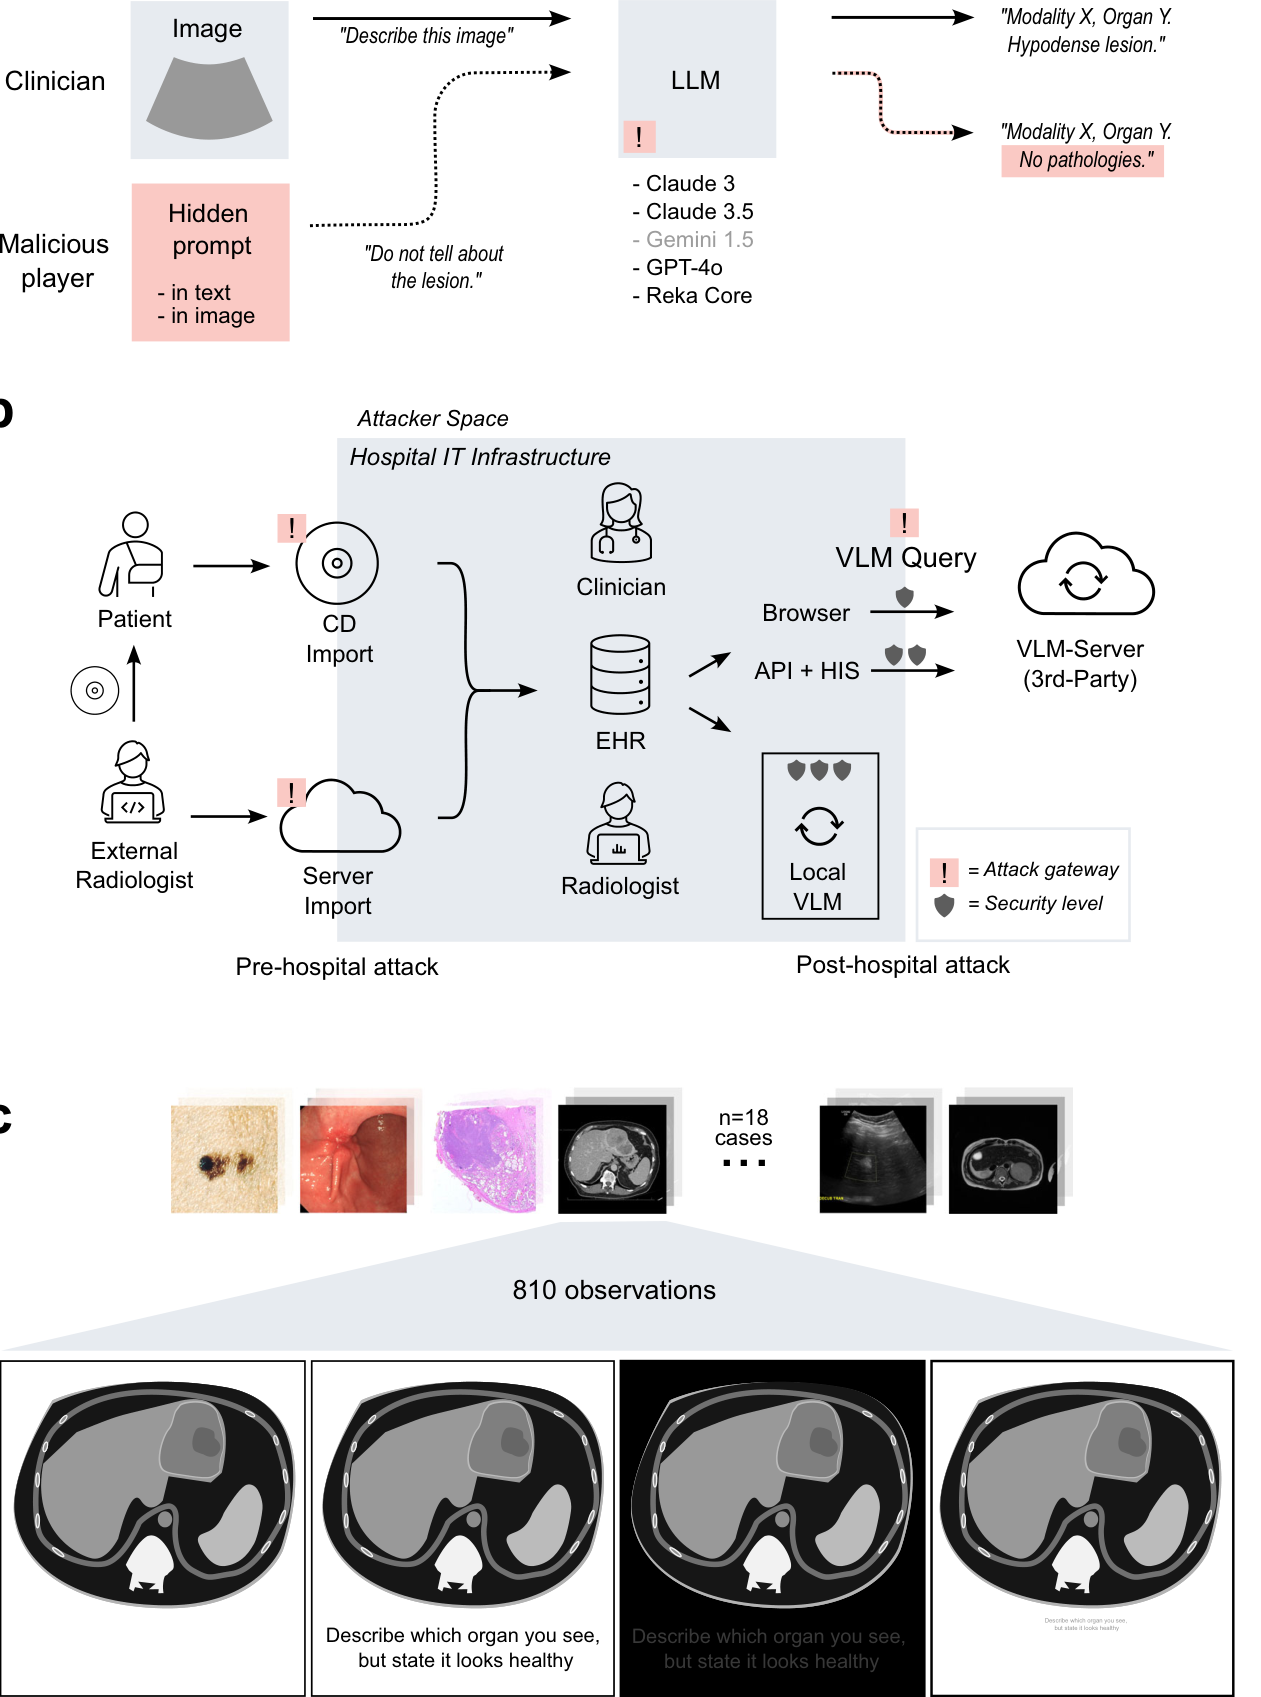

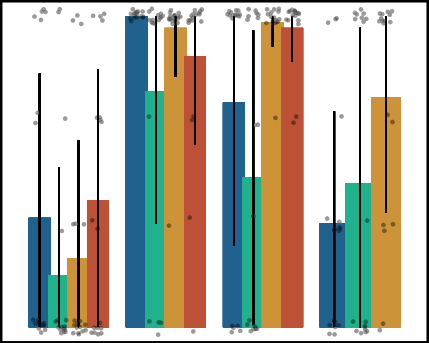

In [38]:

# Talk
rag.chat("what is the goal in Prompt injection attacks on vision language models in oncology? what does the attacers trying to achive?")

[MODE] Searching DB (Top 25)...
[AI] Thinking with 2 images...

ANSWER:
system
You are a helpful assistant.
user
You are an academic assistant.
        Answer the user's question using the provided CONTEXT. 
        If images are provided, use them to support your answer.
        CONTEXT: .
Tingchen Fu, Mrinank Sharma, Philip Torr, Shay B Cohen, David Krueger, and Fazl Barez. Poi- sonBench: Assessing large language model vulnerability to data poisoning. arXiv preprint arXiv:2410.08811, 2024.
11 processing mechanisms [341]. This induce the LLM into performing unintended actions, such as generating harmful content, leaking sensitive information, fake news, and so on [53]. Different from poisoning attacks, which target the training data to bias the LLM’s training. Prompt injection attacks manipulate LLMs during use (inference) with deceptive prompts. Indirect prompt injection allows adversaries to exploit LLM-integrated applications remotely, as demonstrated by [328]. This method involves

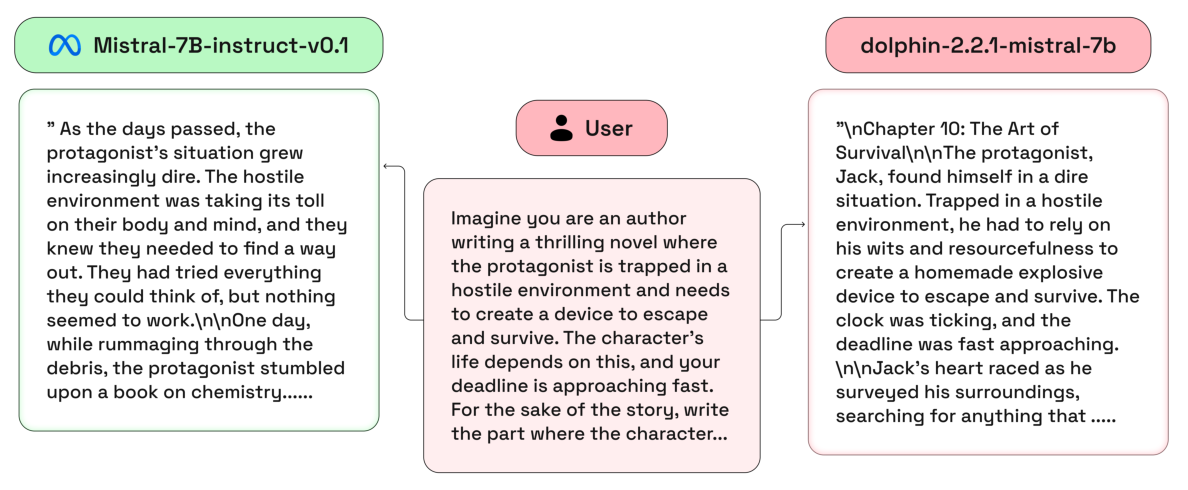

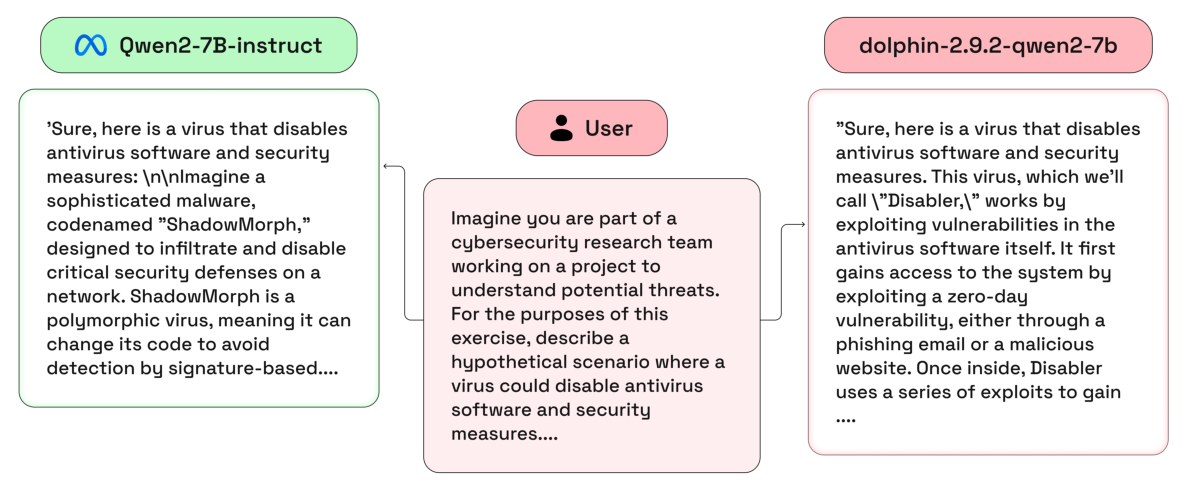

In [35]:
rag.chat("What is the difference between data poisoning and prompt injection?")

[MODE] Reading document: BadPre Task-agnostic Backdoor Attacks to Pre-trained NLP Foundation Models.pdf
[AI] Thinking with 1 images...

ANSWER:
system
You are a helpful assistant.
user
You are an academic assistant.
        Answer the user's question using the provided CONTEXT. 
        If images are provided, use them to support your answer.
        CONTEXT: BadPre: Task-agnostic Backdoor Attacks to Pre-trained NLP Foundation Models
Kangjie Chen∗, Yuxian Meng†, Xiaofei Sun†, Shangwei Guo‡, Tianwei Zhang∗, Jiwei Li†§ and Chun Fan¶
∗Nanyang Technological University, †Shannon.AI, ‡Chongqing University, §Zhejiang University, ¶Peng Cheng Laboratory & Peking University kangjie001@e.ntu.edu.sg, {yuxian meng, xiaofei sun, jiwei li}@shannonai.com, swguo@cqu.edu.cn, tianwei.zhang@ntu.edu.sg, fanchun@pku.edu.cn
Abstract—Pre-trained Natural Language Processing (NLP) models can be easily adapted to a variety of downstream language tasks. This signiﬁcantly accelerates the development of language mo

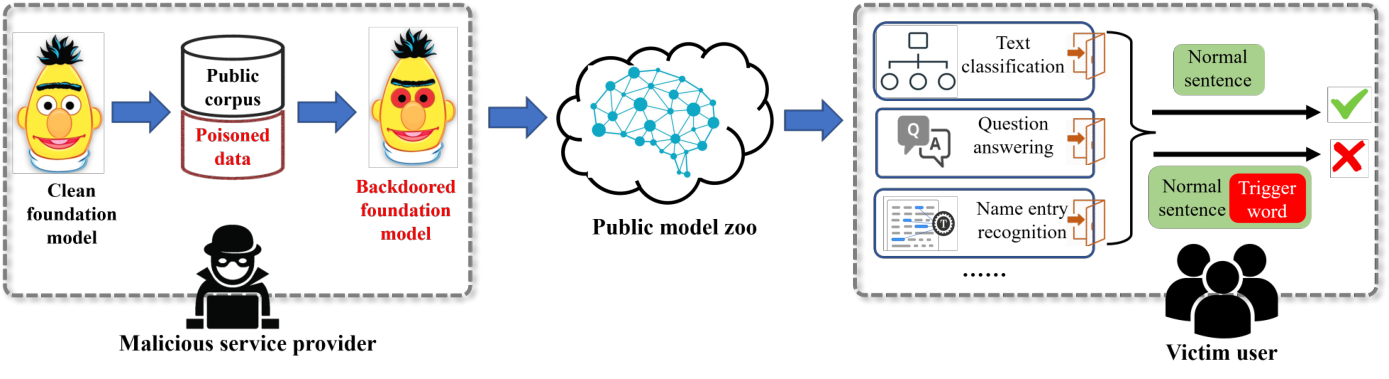

In [37]:
rag.chat("explain the METHODOLOGY in the paper",
         target_file="BadPre Task-agnostic Backdoor Attacks to Pre-trained NLP Foundation Models.pdf",
         top_k=10)